In [1]:
# !pip install tensorflow
# !pip install tqdm
!pip install dtale



Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.7/642.7 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.7/219.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 57.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.7 MB/s eta 0:00:00
   ━━━━━

In [42]:

import matplotlib.pyplot as plt
import logging
import numpy as np
import pandas as pd
import os
import time
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, Concatenate, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from IPython.display import display
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')


In [23]:
## ENABLE GPU Acceleration on M2
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.12.0
Num GPUs Available:  1


# Constants

In [24]:
rolling_window = 10

dfs_cats = ['reb', 'pts', 'ast', 'stl', 'blk', 'tov']
same_game_cols = ['minutes_played', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb',
                   'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka', 'pf', 'pfd', 'pts', 'plus_minus',
                   'nba_fantasy_pts', 'dd2', 'td3', 'wnba_fantasy_pts', 'available_flag', 'e_off_rating', 'off_rating',
                   'sp_work_off_rating', 'e_def_rating', 'def_rating', 'sp_work_def_rating', 'e_net_rating',
                   'net_rating', 'sp_work_net_rating', 'ast_pct', 'ast_to', 'ast_ratio', 'oreb_pct', 'dreb_pct',
                   'reb_pct', 'tm_tov_pct', 'e_tov_pct', 'efg_pct', 'ts_pct', 'usg_pct_x', 'e_usg_pct', 'e_pace',
                   'pace', 'pace_per40', 'sp_work_pace', 'pie', 'poss', 'fgm_pg', 'fga_pg', 'pct_fga_2pt',
                   'pct_fga_3pt', 'pct_pts_2pt', 'pct_pts_2pt_mr', 'pct_pts_3pt', 'pct_pts_fb', 'pct_pts_ft',
                   'pct_pts_off_tov', 'pct_pts_paint', 'pct_ast_2pm', 'pct_uast_2pm', 'pct_ast_3pm', 'pct_uast_3pm',
                   'pct_ast_fgm', 'pct_uast_fgm', 'pct_fgm', 'pct_fga', 'pct_fg3m', 'pct_fg3a', 'pct_ftm', 'pct_fta',
                   'pct_oreb', 'pct_dreb', 'pct_reb', 'pct_ast', 'pct_tov', 'pct_stl', 'pct_blk', 'pct_blka', 'pct_pf',
                   'pct_pfd', 'pct_pts', 'usage_rate', 'fp_draftkings', 'fp_fanduel',
                   'fp_yahoo']


In [25]:
def assign_league_weeks(df):
    df['week'] = df['game_date'].dt.isocalendar().week
    df['season_start'] = df.groupby('season_year')['game_date'].transform('min')
    df['season_week'] = ((df['game_date'] - df['season_start']).dt.days // 7) + 1
    df = df.drop(columns=['season_start', 'week'])
    df = df.rename(columns={'season_week': 'league_week'})
    return df

In [26]:
def rolling_train_test_rnn(X, y, df, num_weeks_for_training=4, time_steps=4, save_model=False, model_dir='models'):
    os.makedirs(model_dir, exist_ok=True)

    # Initialize lists to store predictions and true values
    all_predictions = []
    all_true_values = []
    all_game_ids = []
    all_game_dates = []
    all_player_ids = []
    all_fanduel_salaries = []
    all_draftkings_salaries = []
    all_yahoo_salaries = []
    all_fanduel_positions = []
    all_draftkings_positions = []
    all_yahoo_positions = []

    scaler = MinMaxScaler(feature_range=(0, 1))
    unique_weeks = df['league_week'].unique()

    for current_week in unique_weeks:
        start_week = current_week - num_weeks_for_training
        training_weeks = list(range(start_week, current_week))

        # Select training data (previous 4 weeks)
        X_train = X[X['league_week'].isin(training_weeks)]
        y_train = y.loc[X_train.index]

        # Select test data (current week)
        X_test = X[X['league_week'] == current_week]
        y_test = y.loc[X_test.index]

        if X_train.empty or X_test.empty:
            continue

        identifying_test_data = X_test[['player_name', 'game_date', 'game_id']]
        X_train = X_train.drop(columns=['game_date', 'game_id'])
        X_test = X_test.drop(columns=['game_date', 'game_id'])

        # Scale data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Create sequences for training
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

        # Build and train the RNN model
        model = build_rnn_model((X_train_seq.shape[1], X_train_seq.shape[2]))
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        # Make predictions
        y_pred = model.predict(X_test_seq)

        # Store the predictions and true values
        all_predictions.extend(y_pred.flatten())
        all_true_values.extend(y_test_seq)
        all_game_ids.extend(list(identifying_test_data['game_id'])[time_steps:])
        all_game_dates.extend(list(identifying_test_data['game_date'])[time_steps:])
        all_player_ids.extend(list(identifying_test_data['player_name'])[time_steps:])
        all_fanduel_salaries.extend(X_test['salary-draftkings'].values[time_steps:])
        all_draftkings_salaries.extend(X_test['salary-draftkings'].values[time_steps:])
        all_yahoo_salaries.extend(X_test['salary-yahoo'].values[time_steps:])
        all_fanduel_positions.extend(X_test['pos-draftkings'].values[time_steps:])
        all_draftkings_positions.extend(X_test['pos-draftkings'].values[time_steps:])
        all_yahoo_positions.extend(X_test['pos-yahoo'].values[time_steps:])

        if save_model:
            model_filename = f'{model_dir}/rnn_model_week_{current_week}_trained_on_{start_week}_to_{current_week - 1}.h5'
            model.save(model_filename)

        mse = mean_squared_error(y_test_seq, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_seq, y_pred)

        print(f'Training weeks: {training_weeks}')
        print(f'Test week: {current_week}')
        print(f'Mean Squared Error (MSE): {mse:.2f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
        print(f'R-squared (R²): {r2:.2f}')
        print('')

    results_df = pd.DataFrame({
        'player_name': all_player_ids,
        'game_id': all_game_ids,
        'game_date': all_game_dates,
        'y': all_true_values,
        'y_pred': all_predictions,
        'fanduel_salary': all_fanduel_salaries,
        'draftkings_salary': all_draftkings_salaries,
        'yahoo_salary': all_yahoo_salaries,
        'fanduel_position': all_fanduel_positions,
        'draftkings_position': all_draftkings_positions,
        'yahoo_position': all_yahoo_positions,
    })

    return results_df


In [27]:
def predict_fp_rnn(df, rolling_window=rolling_window):
    df = df.drop('Unnamed: 0', axis=1)
    df['game_date'] = pd.to_datetime(df['game_date'])

    cat_cols = ['team_abbreviation', 'player_name', 'opponent', 'pos-draftkings', 'pos-fanduel', 'pos-yahoo']
    df[cat_cols] = df[cat_cols].astype('category')

    df = df.sort_values(['game_date'], ascending=True)
    df = assign_league_weeks(df)
    df = clean_numeric_columns(df, same_game_cols)
    df = add_time_dependent_features(df, rolling_window=rolling_window)

    all_seasons_results = []

    for season in df['season_year'].unique():
        season_df = df[df['season_year'] == season]
        season_df = season_df.drop('season_year', axis=1)
        season_results = pd.DataFrame()

        for cat in dfs_cats:
            target = cat
            target_related_cols = same_game_cols
            features = season_df.columns.difference(target_related_cols).tolist()

            X = season_df[features]
            y = season_df[target]

            print(f'Training RNN models for {cat}')
            print('---------------------------------')
            cat_results = rolling_train_test_rnn(X=X, y=y, df=season_df)
            cat_results.rename(columns={'y': cat, 'y_pred': f'{cat}_pred'}, inplace=True)
            if len(season_results) == 0:
                season_results = cat_results
            else:
                season_results = pd.merge(
                    season_results,
                    cat_results,
                    on=['player_name', 'game_date', 'game_id', 'fanduel_salary', 'draftkings_salary', 'yahoo_salary', 'draftkings_position', 'fanduel_position', 'yahoo_position'],
                    suffixes=('', f'_{season_df.columns.name}'))
            cat_results.to_csv(f'output_csv/{cat}_{season}_rnn_results.csv', index=False)

        all_seasons_results.append(season_results)

    combined_df = pd.concat(all_seasons_results, ignore_index=True)
    combined_df['fp_fanduel'] = combined_df.apply(lambda row: calculate_fp_fanduel(row), axis=1)
    combined_df['fp_fanduel_pred'] = combined_df.apply(lambda row: calculate_fp_fanduel(row, pred_mode=True), axis=1)

    combined_df['fp_yahoo'] = combined_df.apply(calculate_fp_yahoo, axis=1)
    combined_df['fp_yahoo_pred'] = combined_df.apply(lambda row: calculate_fp_yahoo(row, pred_mode=True), axis=1)

    combined_df['fp_draftkings'] = combined_df.apply(calculate_fp_draftkings, axis=1)
    combined_df['fp_draftkings_pred'] = combined_df.apply(lambda row: calculate_fp_draftkings(row, pred_mode=True),
                                                          axis=1)
    return combined_df



In [28]:
def calculate_fp_fanduel(row, pred_mode=False):
    pred = '_pred' if pred_mode else ''
    return (row[f'pts{pred}'] +
            row[f'reb{pred}'] * 1.2 +
            row[f'ast{pred}'] * 1.5 +
            row[f'stl{pred}'] * 3 +
            row[f'blk{pred}'] * 3 -
            row[f'tov{pred}'] * 1)


def calculate_fp_yahoo(row, pred_mode=False):
    pred = '_pred' if pred_mode else ''
    return (row[f'pts{pred}'] +
            row[f'reb{pred}'] * 1.2 +
            row[f'ast{pred}'] * 1.5 +
            row[f'stl{pred}'] * 3 +
            row[f'blk{pred}'] * 3 -
            row[f'tov{pred}'] * 1)


def calculate_fp_draftkings(row, pred_mode=False):
    pred = '_pred' if pred_mode else ''
    fp = (row[f'pts{pred}'] +
          row[f'reb{pred}'] * 1.25 +
          row[f'ast{pred}'] * 1.5 +
          row[f'stl{pred}'] * 2 +
          row[f'blk{pred}'] * 2 -
          row[f'tov{pred}'] * 0.5)

    # Calculate Double-Double and Triple-Double bonuses
    stats = [row[f'pts{pred}'], row[f'reb{pred}'], row[f'ast{pred}'], row[f'stl{pred}'], row[f'blk{pred}']]
    double_double = sum([1 for stat in stats if stat >= 10]) >= 2
    triple_double = sum([1 for stat in stats if stat >= 10]) >= 3

    if double_double:
        fp += 1.5
    if triple_double:
        fp += 3

    return fp

def clean_numeric_columns(df, columns):
    """
    Convert columns to numeric, forcing errors to NaN, and handle specific non-numeric values.
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert non-numeric to NaN
    return df

def add_time_dependent_features(df, rolling_window):
    for col in same_game_cols:
        logging.info(f"Adding features to {col}")
        gb = df.groupby('player_name')[col]
        df[f'{col}_rolling_{rolling_window}_day_avg'] = gb.transform(
            lambda x: x.rolling(rolling_window, min_periods=1).mean())
        df[f'{col}_rolling_{rolling_window}_day_std'] = gb.transform(
            lambda x: x.rolling(rolling_window, min_periods=1).std())
        df[f'{col}_lag_1'] = gb.shift(1)
        df[f'{col}_lag_2'] = gb.shift(2)
        df[f'{col}_lag_3'] = gb.shift(3)
        df[f'{col}_diff_1'] = gb.diff(1)
        df[f'{col}_diff_2'] = gb.diff(2)
        df[f'{col}_diff_3'] = gb.diff(3)
    return df

# Load

In [29]:
season = '2022-23'
path = f'data/merged_gamelogs_salaries_{season}.csv'
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)

# New Section

In [30]:
df['salary-yahoo'].quantile(0.5)

12.0

In [31]:
df = df[(df['salary-draftkings'] > df['salary-draftkings'].quantile(0.5)) & (df['salary-fanduel'] > df['salary-fanduel'].quantile(0.5)) & (df['salary-yahoo'] > df['salary-yahoo'].quantile(0.5))]

In [11]:
# prompt: show all categorical columns in df_encoded

In [32]:
df['game_date'] = pd.to_datetime(df['game_date'])
df = add_time_dependent_features(df, rolling_window=10)
df = clean_numeric_columns(df, same_game_cols)
df['days_since_start'] = (df['game_date'] - df['game_date'].min()).dt.days  # Convert to days
df = df.drop(columns=['game_date'])  # Drop the original 'game_date' column after conversion

categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
df_encoded = pd.get_dummies(df, columns=categorical_cols)

/var/folders/tr/mh_38szj49lb1ggm801m67l00000gn/T/ipykernel_84769/390402898.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_diff_3'] = gb.diff(3)
/var/folders/tr/mh_38szj49lb1ggm801m67l00000gn/T/ipykernel_84769/390402898.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_{rolling_window}_day_avg'] = gb.transform(
/var/folders/tr/mh_38szj49lb1ggm801m67l00000gn/T/ipykernel_84769/390402898.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [33]:
[col for col in df_encoded.columns if df_encoded[col].dtype == 'object']

[]

## Model Training Fixed

In [34]:

def create_sequences(data, sequence_length, target_column):
    """
    Create sequences and labels from the data for time series modeling.

    Parameters:
    - data: The input DataFrame.
    - sequence_length: Number of previous time steps to include in each sequence.
    - target_column: The column that contains the target values ('fp_draftkings', 'fp_fanduel', or 'fp_yahoo').

    Returns:
    - sequences: The feature sequences of shape (num_sequences, sequence_length, num_features).
    - labels: The corresponding labels for each sequence.
    """
    sequences = []
    labels = []

    # Drop all target columns (including the current target_column) to avoid leakage
    drop_cols = ['fp_draftkings', 'fp_fanduel', 'fp_yahoo']

    # Use tqdm to add a progress bar
    for i in tqdm(range(len(data) - sequence_length), desc="Creating Sequences"):
        # Create the sequence of past game data (dropping all target columns)
        sequence = data.iloc[i:i + sequence_length].drop(columns=drop_cols).values

        # The target value is for the next game after the sequence (label)
        label = data.iloc[i + sequence_length][target_column]

        # Append the sequence and corresponding label
        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels)



In [35]:
def train_and_evaluate_model(df_encoded, platform, sequence_length=10, epochs=50):
    print(f"\nTraining model for platform: {platform.upper()}")
    target_column = f'fp_{platform}'

    # Let's say you want to create sequences for the 'fp_draftkings' target column with a sequence length of 10
    start_time_seq = time.perf_counter()
    # sequence_length = 10
    X, y = create_sequences(df_encoded, sequence_length=sequence_length, target_column=target_column)

    end_time_seq = time.perf_counter()
    print(f"Time taken to create sequences: {end_time_seq - start_time_seq:.2f} seconds")

    start_time_preprocess = time.perf_counter()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Flatten the sequences for scaling
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])

    # Fit the scaler on training data and transform both train and test sets
    X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

    # Ensure the data is in float32 format
    X_train_scaled = X_train_scaled.astype(np.float32)
    X_test_scaled = X_test_scaled.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

    # Check if there are any NaN or inf values in your data
    print(np.isnan(X_train_scaled).sum(), np.isinf(X_train_scaled).sum())
    print(np.isnan(y_train).sum(), np.isinf(y_train).sum())

    # Remove or replace NaN or inf values if they exist
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

    print(np.isnan(X_train_scaled).sum(), np.isinf(X_train_scaled).sum())
    print(np.isnan(y_train).sum(), np.isinf(y_train).sum())

    end_time_preprocess = time.perf_counter()
    print(f"Time taken for data preprocessing: {end_time_preprocess - start_time_preprocess:.2f} seconds")

    start_time_training = time.perf_counter()
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model using scaled training and validation data
    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

    end_time_training = time.perf_counter()
    print(f"Time taken for model training: {end_time_training - start_time_training:.2f} seconds")

    total_time = end_time_training - start_time_seq
    print(f"Total execution time: {total_time:.2f} seconds")

    # Plot the training and validation loss
    plt.plot(model.history.history['loss'], label='Training Loss')
    plt.plot(model.history.history['val_loss'], label='Validation Loss')
    plt.title(f'RNN Training and Validation Loss{platform}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation metrics
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R-squared (R²): {r2}')

    # Collect results
    result = {
        'pred_name': 'RNN',
        'nba_season': season,
        'DFS platform': platform,
        'test_MAE': mae,
        'test_RMSE': rmse,
        'R²': r2,
        'rolling_window': rolling_window,  # Adjust if different
        'seq_length': sequence_length,
        'train_epochs': epochs
    }

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'Actual vs RNN-Predicted Fantasy Points {platform}')
    plt.xlabel('Game Index')
    plt.ylabel('Fantasy Points')
    plt.legend()
    plt.show()

    return result


# RNN Model Runs on Each Platform:


Training model for platform: DRAFTKINGS


Creating Sequences: 100%|██████████| 10679/10679 [00:07<00:00, 1507.89it/s]


Time taken to create sequences: 9.03 seconds
2974820 0
0 0
0 0
0 0
Time taken for data preprocessing: 8.65 seconds
Epoch 1/50
267/267 [==============================] - 6s 16ms/step - loss: 365.8151 - val_loss: 195.6917
Epoch 2/50
267/267 [==============================] - 3s 11ms/step - loss: 160.1895 - val_loss: 125.0989
Epoch 3/50
267/267 [==============================] - 3s 12ms/step - loss: 114.0580 - val_loss: 112.3075
Epoch 4/50
267/267 [==============================] - 3s 12ms/step - loss: 96.1904 - val_loss: 114.5515
Epoch 5/50
267/267 [==============================] - 3s 12ms/step - loss: 82.1644 - val_loss: 116.8134
Epoch 6/50
267/267 [==============================] - 3s 11ms/step - loss: 68.3877 - val_loss: 120.1020
Epoch 7/50
267/267 [==============================] - 3s 12ms/step - loss: 58.7829 - val_loss: 125.3044
Epoch 8/50
267/267 [==============================] - 3s 12ms/step - loss: 51.3324 - val_loss: 125.7227
Epoch 9/50
267/267 [==============================

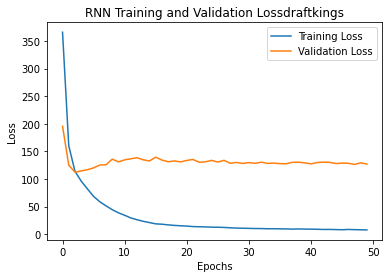

67/67 [==============================] - 1s 4ms/step
Mean Absolute Error (MAE): 8.718761444091797
Root Mean Squared Error (RMSE): 11.270041465759277
R-squared (R²): 0.3115276408791616


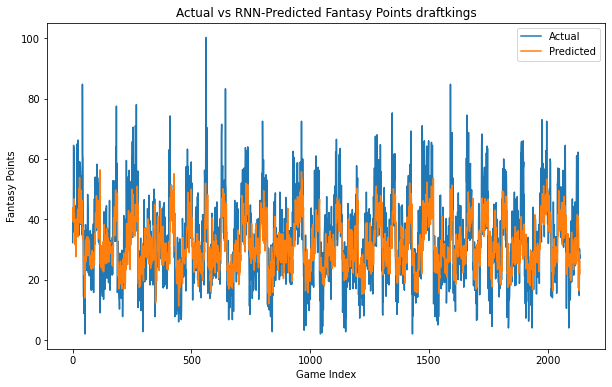


Training model for platform: FANDUEL


Creating Sequences: 100%|██████████| 10679/10679 [00:07<00:00, 1371.14it/s]


Time taken to create sequences: 9.04 seconds
2974820 0
0 0
0 0
0 0
Time taken for data preprocessing: 8.16 seconds
Epoch 1/50
267/267 [==============================] - 5s 13ms/step - loss: 334.3886 - val_loss: 184.8000
Epoch 2/50
267/267 [==============================] - 3s 11ms/step - loss: 145.0497 - val_loss: 118.0331
Epoch 3/50
267/267 [==============================] - 3s 11ms/step - loss: 107.9681 - val_loss: 107.8757
Epoch 4/50
267/267 [==============================] - 3s 11ms/step - loss: 90.7145 - val_loss: 108.2041
Epoch 5/50
267/267 [==============================] - 3s 11ms/step - loss: 77.5246 - val_loss: 113.1602
Epoch 6/50
267/267 [==============================] - 3s 12ms/step - loss: 66.4354 - val_loss: 113.1045
Epoch 7/50
267/267 [==============================] - 3s 11ms/step - loss: 57.3473 - val_loss: 116.0137
Epoch 8/50
267/267 [==============================] - 3s 11ms/step - loss: 51.9587 - val_loss: 117.8963
Epoch 9/50
267/267 [==============================

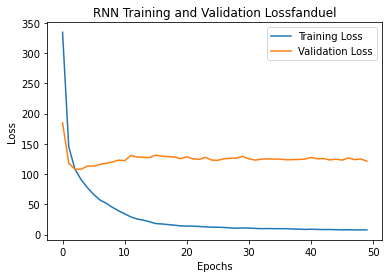

67/67 [==============================] - 1s 4ms/step
Mean Absolute Error (MAE): 8.487211227416992
Root Mean Squared Error (RMSE): 11.013427734375
R-squared (R²): 0.31441327077923054


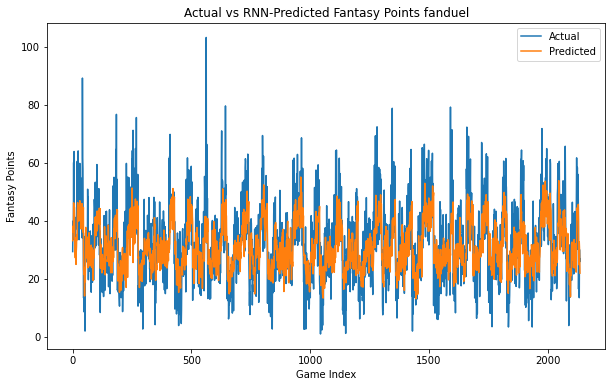


Training model for platform: YAHOO


Creating Sequences: 100%|██████████| 10679/10679 [00:07<00:00, 1511.52it/s]


Time taken to create sequences: 8.28 seconds
2974820 0
0 0
0 0
0 0
Time taken for data preprocessing: 8.07 seconds
Epoch 1/50
267/267 [==============================] - 5s 13ms/step - loss: 334.5312 - val_loss: 184.5515
Epoch 2/50
267/267 [==============================] - 3s 11ms/step - loss: 147.7745 - val_loss: 122.5074
Epoch 3/50
267/267 [==============================] - 3s 11ms/step - loss: 110.4196 - val_loss: 111.4044
Epoch 4/50
267/267 [==============================] - 4s 14ms/step - loss: 92.7912 - val_loss: 109.4419
Epoch 5/50
267/267 [==============================] - 4s 13ms/step - loss: 79.8692 - val_loss: 113.1522
Epoch 6/50
267/267 [==============================] - 3s 11ms/step - loss: 67.6751 - val_loss: 116.6654
Epoch 7/50
267/267 [==============================] - 3s 11ms/step - loss: 57.7333 - val_loss: 125.4538
Epoch 8/50
267/267 [==============================] - 3s 12ms/step - loss: 50.1876 - val_loss: 130.7620
Epoch 9/50
267/267 [==============================

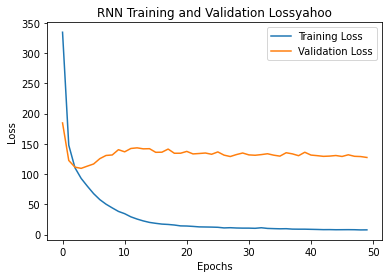

67/67 [==============================] - 1s 4ms/step
Mean Absolute Error (MAE): 8.688376426696777
Root Mean Squared Error (RMSE): 11.288958549499512
R-squared (R²): 0.2796806386407753


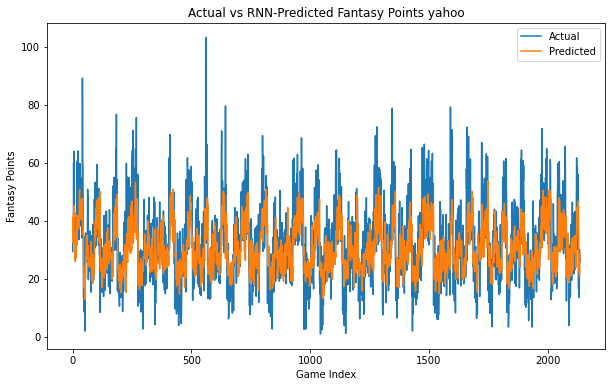

In [36]:
# List to store results
results = []

# Platforms to iterate over
platforms = ['draftkings', 'fanduel', 'yahoo']

for platform in platforms:
    result = train_and_evaluate_model(df_encoded, platform, sequence_length=10, epochs=50)
    results.append(result)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)


In [50]:
# Display results dictionary/df & save results to a CSV file
display(results_df)
results_df.to_csv(f'model_results_RNN_{season}.csv', index=False)


,model_name,nba_season,rolling_window,sequence_length,platform,training_epochs,test_MAE,test_RMSE,R-squared
0,RNN,2022-23,10,10,draftkings,50,8.718761,11.270041,0.311528
1,RNN,2022-23,10,10,fanduel,50,8.487211,11.013428,0.314413
2,RNN,2022-23,10,10,yahoo,50,8.688376,11.288959,0.279681
